# Likelihood Fit with MCMC
 >__Created__:  October 2021, Virtual, LPC Course: Statistics in Particle Physics.<br>
 >__Updated__: May 2022, INFN School of Statistics
 
 
 This notebook gives a basic introduction to the use of MCMC to sample a likelihood. 

In [2]:
# standard system modules
import os, sys

# standard table manipulation module
#import pandas as pd

# standard array manipulation module
import numpy as np

# standard scientific python module
import scipy as sp
import scipy.stats as st
import scipy.optimize as op

# MCMC 
import emcee as em

# dump and load objects to/from disk 
import joblib as jb

# standard symbolic algebra pakage
import sympy as sm

# standard plotting module
import matplotlib as mp
import matplotlib.pyplot as plt

# make plots appear inline
%matplotlib inline

In [3]:
# update fonts
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 20
        }
mp.rc('font', **font)
mp.rc('xtick', labelsize='x-small')
mp.rc('ytick', labelsize='x-small')

# set usetex = False if Latex is not available on your system
mp.rc('text', usetex=True)

# set a seed to ensure reproducibility 
# on a given machine
seed = 111
rnd = np.random.RandomState(seed)

### Load data

$m(x | a, b) = P \, a \exp(-a x) + (1-P) \, b \exp(-b x)$

Format of data file:
```python
F: P * np.exp(-x/a)/a + (1-P) * np.exp(-x/b)/b
A:      5.000
B:     10.000
P:      0.667
     2.659
    17.451
     0.621
    12.218
        :
```

In [4]:
# read all records
records = [x.strip() for x in open('likelihood_data.txt').readlines()]

# get model formula
model   = records[0].split(': ')[-1]

# get true parameters (a, b, and p)
A, B, P = [float(x.split()[-1]) for x in records[1:4]]

# read data
X       = np.array([float(x) for x in records[4:]])

model, A, B, P, X

('P * np.exp(-x/a)/a + (1-P) * np.exp(-x/b)/b',
 5.0,
 10.0,
 0.667,
 array([ 2.659, 17.451,  0.621, 12.218,  9.26 ,  8.134,  5.046,  5.066,
         1.21 , 43.149, 10.258,  3.229, 10.135, 18.063,  1.768,  0.13 ,
         6.618,  1.23 ,  9.509,  6.428,  9.125,  2.777,  6.33 ,  0.143,
         0.687,  1.153, 26.605,  3.086, 16.848, 10.318,  3.633,  8.042,
         1.034,  0.262,  2.168,  6.474,  0.827,  7.606,  8.019,  0.425]))

Create model

In [5]:
record = '''
def F(x, a, b):
    return %s
''' % model
print(record)

exec(record)


def F(x, a, b):
    return P * np.exp(-x/a)/a + (1-P) * np.exp(-x/b)/b



In [6]:
def plot_data(d, f, 
              nbins=20, 
              xmin=0, xmax=40, 
              ymin=0, ymax=0.4, 
              ftsize=20, 
              color=(0,0,1), 
              fgsize=(5, 5)):
    
    h = (xmax-xmin)/nbins
    x = np.arange(xmin, xmax, h)
    
    # set size of figure
    fig = plt.figure(figsize=fgsize)

    plt.xlim([xmin, xmax])
    plt.ylim([ymin, ymax])
    
    # annotate axes
    plt.xlabel(r'$x$', fontsize=ftsize)
    plt.ylabel(r'$f(x, a, b)$', fontsize=ftsize)
    
    # histogram data
    # returns y, x, o
    # y: counts
    # x: bin boundaries
    # o: objects
    
    w = np.ones(len(d))/len(d)
    plt.hist(d, 
             weights=w,
             bins=nbins, 
             color='steelblue', 
             alpha=0.3,
             range=(xmin, xmax)) 
    
    g = f(x, A, B) * h
    plt.plot(x, g, color='red')
    
    fig.tight_layout()
    plt.savefig('fig_exp_data.pdf')
    plt.show()

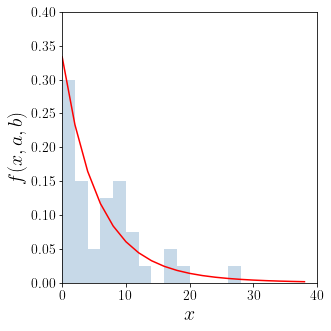

In [7]:
plot_data(X, F)

### Define log-likelihood (ll)

In [8]:
AMIN = 0.1
AMAX = 16
BMIN = 0.1
BMAX = 25

def ll(params, big=1e3):
    a, b = params
    
    if a < AMIN: return -big
    if a > AMAX: return -big
    
    if b < BMIN: return -big
    if b > BMAX: return -big

    f = np.log(F(X, a, b)).sum()
 
    #print('%10.3f\t%10.3f,%10.3f' % (f,a,b))
    if np.isnan(f):
        return -big
    else:
        return f

## Use emcee for sampling 

https://emcee.readthedocs.io/en/stable/tutorials/line/

Perform sampling with several walkers

$m(x | a, b) = p \, \exp(-x / a) / a + (1-p) \exp(-x / b) / b$ 

In [9]:
# initial state of MCMC (parameter points)
npars    = 2      # number of parameters
niter    = 100000 # number of iterations
nwalkers = 10     # number of MCMC chains

# random initial values
initial  = np.abs(5 + 2*np.random.randn(nwalkers, npars))

### Run MCMC

In [10]:
sampler = em.EnsembleSampler(nwalkers, npars, ll)

sampler.run_mcmc(initial, niter, progress=True)
    
print(sampler.acceptance_fraction)

fname = 'likelihood_mcmc.db'
jb.dump(sampler, fname)
print('\nsaved MCMC data to: %s' % fname)

100%|█████████████████████████████████| 100000/100000 [00:20<00:00, 4947.96it/s]

[0.67037 0.66903 0.66961 0.66796 0.67161 0.66905 0.67228 0.67076 0.67295
 0.67015]

saved MCMC data to: likelihood_mcmc.db


In [11]:
ndiscard = 10000
nthin    = 10
sample   = sampler.get_chain(discard=ndiscard, 
                             thin=nthin, 
                             flat=True)
print(sample.shape,(niter-ndiscard)*nwalkers/nthin)

(90000, 2) 90000.0


In [12]:
def compute_lhood(loglike, 
                  nsteps=100, 
                  xmin=AMIN, xmax=AMAX,
                  ymin=BMIN, ymax=BMAX):
    
    # 1. first create a mesh grid
    xdelta = float(xmax-xmin)/nsteps
    ydelta = float(ymax-ymin)/nsteps
    x      = np.arange(xmin, xmax, xdelta)
    y      = np.arange(ymin, ymax, ydelta)
    x, y   = np.meshgrid(x, y)
    
    # 2. compute likelihoods at all mesh grid points
    z = [loglike((a, b)) for a, b in zip(x.flatten(), y.flatten())]
    z = np.array(z).reshape(x.shape)
    z = np.exp(z)

    return (x, y, z)

In [13]:
pts = compute_lhood(ll)

In [14]:
def plot_lhood(points, sample,
               nsteps=50, 
               xmin=AMIN, xmax=AMAX, 
               ymin=BMIN, ymax=BMAX, 
               ftsize=20, 
               fgsize=(6, 6)):

    # set size of figure
    fig = plt.figure(figsize=fgsize)
    
    plt.xlim([xmin, xmax])
    plt.locator_params(axis='x', nbins=4)
    
    plt.ylim([ymin, ymax])
    plt.locator_params(axis='y', nbins=4)
    
    # annotate axes
    plt.xlabel(r'$a$', fontsize=ftsize)
    plt.ylabel(r'$b$', fontsize=ftsize)

    # plot contours
    rainbow = plt.get_cmap('rainbow')
    x, y, z = points
    plt.contour(x, y, z, cmap=rainbow)
    
    # plot MCMC points
    gist_earth = plt.get_cmap('gist_earth')
    xx = sample.transpose()[0]
    yy = sample.transpose()[1]
    h  = plt.hist2d(xx, yy, bins=50, 
                    range=([[xmin, xmax], [ymin, ymax]]), 
                    cmap=gist_earth, 
                    norm=mp.colors.LogNorm())
    
    fig.tight_layout()
    plt.savefig('fig_likelihood_mcmc.png')
    plt.show()

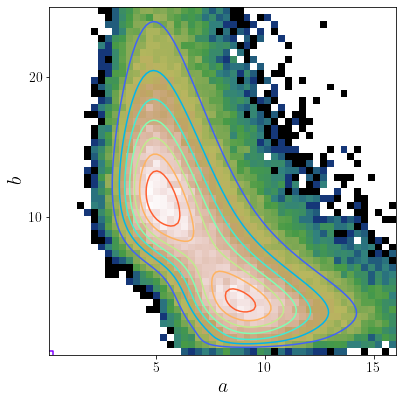

In [15]:
plot_lhood(pts, sample)